# Import packages

In [1]:
#Import packages
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder

# Read files and split into train and test

In [2]:
train_final = pd.read_csv("C:/RAHIM/MMA -QUEEN'S/Marketing Analytics - MMA 831/Airbnb/train_final.csv")
train1 = train_final.iloc[0:213451,:]
test = train_final.iloc[213451:275547,:]

In [4]:
#Further split into train and validate
#train test split dataset to measure performance. Original test_users dataset provided by airbnb does not come with labels
# so we need to create our own test set
x_train,x_test,y_train,y_test = train_test_split(train1,train1['country_destination'],test_size=0.25,random_state=1)

# Model building Decision Trees

In [6]:
#Checking accuracy of the model with all features 184 in total.

#import packages used for model evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,f1_score,recall_score
def score(true,pred):
    return(precision_score(true,pred,average='weighted'),
          recall_score(true,pred,average='weighted'),
          f1_score(true,pred,average='weighted'))

#import DecisionTreeClassifier package
from sklearn.tree import DecisionTreeClassifier

#DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=20, min_samples_leaf=20, max_depth=30, max_leaf_nodes=40)
dtc.fit(x_train.iloc[:,8:192], y_train)
y_preds_dtc = dtc.predict(x_test.iloc[:,8:192])  

#DecisionTreeClassifier accuracy score - 63.46% with all features.

DTC = accuracy_score(y_test,y_preds_dtc)
DTC

0.6346157449918483

# Feature Selection

In [39]:
from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
from sklearn.tree import DecisionTreeClassifier


# Helper function
def evaluate_with_dt(x_train, x_test, y_train, y_test):
    clf_full = DecisionTreeClassifier(random_state=0)
    clf_full.fit(x_train.iloc[:,8:192], y_train)
    y_pred_dt = clf_full.predict(x_test.iloc[:,8:192])
    print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
    print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
   

In [40]:
evaluate_with_dt(x_train.iloc[:,8:192], x_test.iloc[:,8:192], y_train , y_test)

Accuracy = 0.56
Kappa = 0.16


# Variance Threshold (Filter Method, Unsupervised)

In [42]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.1));
sel.fit(x_train.iloc[:,8:192]);

In [43]:
sel.variances_
sel.get_support()
sum(sel.get_support())

33

In [46]:
y_train.head()

72140     NDF
77397     NDF
163938    NDF
129449    NDF
25397     NDF
Name: country_destination, dtype: object

In [47]:
X_train_new = x_train.loc[:, sel.get_support()]
X_test_new = x_test.loc[:, sel.get_support()]

evaluate_with_dt(X_train_new, X_test_new, y_train, y_test)

#Observation: with 33 features our accuracy is 63%

Accuracy = 0.63
Kappa = 0.27


# Univariate Feature Selection (Filter Method, Supervised)

In [96]:
from sklearn.feature_selection import SelectKBest, chi2

sel = SelectKBest(chi2, k=33)
sel.fit(x_train.iloc[:,8:192], y_train)

SelectKBest(k=33, score_func=<function chi2 at 0x000001E68B0AF510>)

In [97]:
sel.pvalues_
sel.get_support()

array([False,  True,  True, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
       False, False,

In [98]:
X_train_new = x_train.loc[:, sel.get_support()]
X_test_new = x_test.loc[:, sel.get_support()]

evaluate_with_dt(X_train_new, X_test_new, y_train, y_test)

Accuracy = 0.59
Kappa = 0.00


In [99]:
#Observation with different K values
#K	Accuracy
#20	0.59
#30	0.59
#40	0.59
#50	0.59
#60	0.58
#75	0.58
#100	0.57
#150	0.56
#175	0.55

# Recursive Feature Elimination (Wrapper Method)

In [82]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier

clf = DecisionTreeClassifier(random_state=0)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(20), scoring='accuracy')
%time rfecv.fit(x_train.iloc[:,8:192], y_train)

Wall time: 3h 6min 9s


RFECV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
   estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [84]:
print("Optimal number of features : %d" % rfecv.n_features_)
rfecv.get_support(indices=True)
x_train.iloc[:,8:192].columns[rfecv.get_support()]

Optimal number of features : 3


Index(['date_account_created_year', 'Age_unknown', 'signup_method_facebook'], dtype='object')

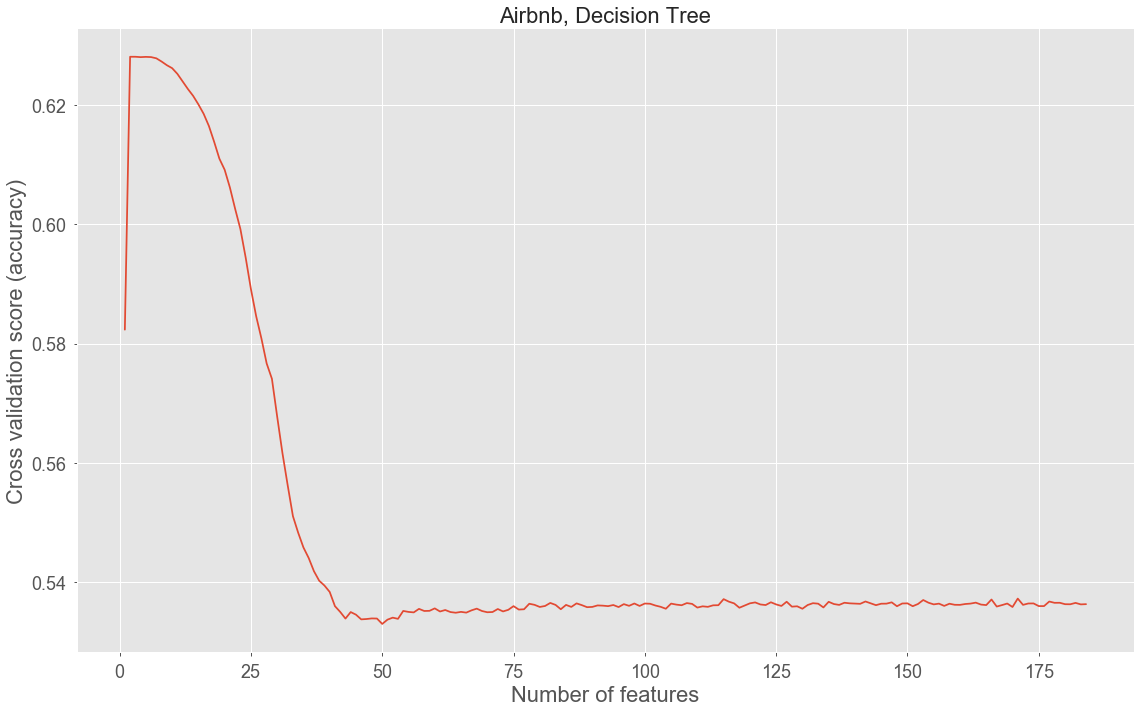

In [86]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(16, 10));
plt.grid(True);
plt.title('Airbnb, Decision Tree', fontsize=22);
plt.xlabel("Number of features", fontsize=22);
plt.ylabel("Cross validation score (accuracy)", fontsize=22);
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();
plt.savefig('AirSimClient.write_file-py1.png');

# Hyperparameter Tuning

In [100]:
def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    results['mean_fit_time'] = cv_results['mean_fit_time']
    results['mean_score_time'] = cv_results['mean_score_time']
    results['mean_train_score'] = cv_results['mean_train_score']
    results['std_train_score'] = cv_results['std_train_score']
    results['mean_test_score'] = cv_results['mean_test_score']
    results['std_test_score'] = cv_results['std_test_score']
    results['rank_test_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_test_score'], ascending=False)
    return results

In [102]:
from sklearn.model_selection import GridSearchCV

hyperparams = {'criterion':('gini', 'entropy'), 
               'max_depth':[1, 5, 10, 50],
               'max_leaf_nodes': [5, 20, 100]}
clf = DecisionTreeClassifier(min_samples_split=2)
gridsearch = GridSearchCV(clf, hyperparams, cv=5, return_train_score=True)
%time gridsearch.fit(x_train.iloc[:,8:192], y_train)

Wall time: 3min 4s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ('gini', 'entropy'), 'max_depth': [1, 5, 10, 50], 'max_leaf_nodes': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [103]:
results = cv_results_to_df(gridsearch.cv_results_)
results

,criterion,max_depth,max_leaf_nodes,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
8,gini,10,100,2.134306,0.053123,0.633742,0.000478,0.632308,0.000928,1
11,gini,50,100,2.112590,0.056254,0.633781,0.000560,0.632159,0.000839,2
20,entropy,10,100,2.146844,0.053124,0.633010,0.000510,0.631952,0.001070,3
23,entropy,50,100,2.262377,0.053130,0.632902,0.000666,0.631740,0.001109,4
5,gini,5,100,1.596937,0.065621,0.632221,0.000223,0.631315,0.000951,5
17,entropy,5,100,1.440866,0.059372,0.631532,0.000561,0.631015,0.001066,6
4,gini,5,20,1.219046,0.056249,0.630464,0.000253,0.630428,0.001210,7
7,gini,10,20,1.481998,0.056248,0.630464,0.000253,0.630428,0.001210,7
10,gini,50,20,1.281346,0.050008,0.630464,0.000253,0.630428,0.001210,7
16,entropy,5,20,1.218952,0.046875,0.630253,0.000468,0.630185,0.000933,10


In [106]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

hyperparam_dist = {"max_depth": sp_randint(1, 50),
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]}

clf = DecisionTreeClassifier(min_samples_split=2)
randomsearch = RandomizedSearchCV(clf, param_distributions=hyperparam_dist, 
                                  cv=5, return_train_score=True, n_iter=100, iid='warn');
%time randomsearch.fit(x_train.iloc[:,8:192], y_train);

Wall time: 7min 22s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=100, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E68BE31B00>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E68BE316A0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E68BE31C50>, 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [107]:
cv_results_to_df(randomsearch.cv_results_)

,criterion,max_depth,max_features,min_samples_split,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
55,gini,15,10,4,0.509518,0.065623,0.625584,0.010144,0.612638,0.008079,1
24,gini,17,9,7,0.610529,0.070633,0.634595,0.007976,0.612026,0.008372,2
96,gini,18,9,8,0.493895,0.062496,0.634368,0.007767,0.611208,0.008360,3
99,gini,14,10,3,0.509511,0.062497,0.622239,0.006863,0.609996,0.007762,4
84,gini,19,8,3,0.709303,0.081392,0.647948,0.006500,0.609640,0.007694,5
4,gini,21,9,8,0.562497,0.062497,0.638630,0.010365,0.608003,0.003069,6
62,entropy,17,10,8,0.515342,0.053123,0.637340,0.005124,0.607816,0.005911,7
70,entropy,18,6,7,0.459947,0.058935,0.627389,0.004714,0.602700,0.009243,8
43,gini,12,6,7,0.490771,0.078123,0.605680,0.012423,0.602637,0.013057,9
15,entropy,13,7,8,0.416673,0.056249,0.607549,0.015483,0.602394,0.015068,10
